In [ ]:
import numpy as np
import nltk
import pandas as pd
import collections
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount("/content/drive/")
df=pd.read_csv("drive/My Drive/NLP summer Internship/Cleanned_Complaints.csv")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Part 0 Splitting vendor dataset

In [ ]:
# Show label distribution for the whole original dataset
df=df[df["Label"]!="Other financial service"]
df=df.dropna()
df.groupby("Label")["Complaint"].count()

Label
Bank account or service                                                          14885
Checking or savings account                                                      22432
Consumer Loan                                                                     9473
Credit card or prepaid card                                                      58842
Credit reporting, credit repair services, or other personal consumer reports    212844
Debt collection                                                                 116674
Money transfer, virtual currency, or money service                               10691
Mortgage                                                                         66255
Payday loan, title loan, or personal loan                                         9189
Student loan                                                                     26410
Vehicle loan or lease                                                             9486
Name: Complaint, dtype: int64

In [ ]:
# Groupby company and count complaints
df.groupby("Company")["Label"].count().sort_values(ascending=False)[:20]

Company
EQUIFAX, INC.                             61364
Experian Information Solutions Inc.       56341
TRANSUNION INTERMEDIATE HOLDINGS, INC.    55056
CITIBANK, N.A.                            18255
WELLS FARGO & COMPANY                     17613
BANK OF AMERICA, NATIONAL ASSOCIATION     17287
JPMORGAN CHASE & CO.                      17176
CAPITAL ONE FINANCIAL CORPORATION         15009
Navient Solutions, LLC.                   14874
SYNCHRONY FINANCIAL                        9991
AMERICAN EXPRESS COMPANY                   6414
Ocwen Financial Corporation                5809
U.S. BANCORP                               5584
NATIONSTAR MORTGAGE                        5564
AES/PHEAA                                  5506
PORTFOLIO RECOVERY ASSOCIATES INC          5485
ENCORE CAPITAL GROUP INC.                  4615
DISCOVER BANK                              4480
Alliance Data Card Services                4221
Ditech Financial LLC                       3977
Name: Label, dtype: int64

In [ ]:
# Prepare four vendor datasets and one Well's Fargo set
df_wells=df[df["Company"]=="WELLS FARGO & COMPANY"]
credit_unions=["TRANSUNION INTERMEDIATE HOLDINGS, INC."]
banks=["CITIBANK, N.A.","BANK OF AMERICA, NATIONAL ASSOCIATION","JPMORGAN CHASE & CO.","U.S. BANCORP"]
mortgages=["Ocwen Financial Corporation","NATIONSTAR MORTGAGE","Ditech Financial LLC","SELECT PORTFOLIO SERVICING, INC.",
           "Specialized Loan Servicing Holdings LLC","SYNCHRONY FINANCIAL"]
balanced=["Santander Consumer USA Holdings Inc.","Ocwen Financial Corporation","BANK OF AMERICA, NATIONAL ASSOCIATION",
          "JPMORGAN CHASE & CO.","U.S. BANCORP","PNC Bank N.A.","UNITED SERVICES AUTOMOBILE ASSOCIATION","SUNTRUST BANKS, INC."]
df_cu=df[df["Company"].isin(credit_unions)]
df_banks=df[df["Company"].isin(banks)]
df_mortgages=df[df["Company"].isin(mortgages)]
df_balanced=df[df["Company"].isin(balanced)]

In [ ]:
# Dataset label distributions
cu_label_count=df_cu.groupby("Label")["Complaint"].count()/len(df_cu)
banks_label_count=df_banks.groupby("Label")["Complaint"].count()/len(df_banks)
mortgages_label_count=df_mortgages.groupby("Label")["Complaint"].count()/len(df_mortgages)
balanced_label_count=df_balanced.groupby("Label")["Complaint"].count()/len(df_balanced)
wells_label_count=df_wells.groupby("Label")["Complaint"].count()/len(df_wells)
print("Check Credit Union dataset labels")
print(cu_label_count)
print("Check Banks dataset labels")
print(banks_label_count)
print("Check Mortgages dataset labels")
print(mortgages_label_count)
print("Check Wells Fargo dataset labels")
print(wells_label_count)

Check Credit Union dataset labels
Label
Bank account or service                                                         0.000036
Checking or savings account                                                     0.000054
Consumer Loan                                                                   0.000182
Credit card or prepaid card                                                     0.001181
Credit reporting, credit repair services, or other personal consumer reports    0.983835
Debt collection                                                                 0.013532
Money transfer, virtual currency, or money service                              0.000091
Mortgage                                                                        0.000272
Payday loan, title loan, or personal loan                                       0.000163
Student loan                                                                    0.000363
Vehicle loan or lease                                                 

In [ ]:
# Check number of documents in each dataset
cu_complaint=df_cu["Complaint_reduced"]
banks_complaint=df_banks["Complaint_reduced"]
mortgages_complaint=df_mortgages["Complaint_reduced"]
balanced_complaint=df_balanced["Complaint_reduced"]
wells_complaint=df_wells["Complaint_reduced"]
print(cu_complaint.shape,banks_complaint.shape,mortgages_complaint.shape,balanced_complaint.shape,wells_complaint.shape)

(55056,) (58302,) (29905,) (57125,) (17613,)


In [ ]:
# Helper function for tokenizers
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
def tokenizing(df,max_features):
  vectorizer=CountVectorizer(max_features=max_features)
  X= vectorizer.fit_transform(df)
  return vectorizer,X

def tfidf_tokenizing(df,max_features,norm):
  vectorizer=TfidfVectorizer(use_idf=True,norm=norm,smooth_idf=True,max_features=max_features)
  X= vectorizer.fit_transform(df)
  return vectorizer,X

#### Part 1 EDA - overlapping tokens

In [ ]:
# Compare words overlapping first m frequent words for the whole dataset
# Number of word overlapping/m 
cu_wells=[]
mortgages_wells=[]
banks_wells=[]
balanced_wells=[]
for i in range(1,6):
  max_features=i*1000
  #vectorizer
  cu_vectorizer,X_cu=tokenizing(cu_complaint,max_features)
  banks_vectorizer,X_banks=tokenizing(banks_complaint,max_features)
  mortgages_vectorizer,X_mortgages=tokenizing(mortgages_complaint,max_features)
  balanced_vectorizer,X_balanced=tokenizing(balanced_complaint,max_features)
  wells_vectorizer,X_wells=tokenizing(wells_complaint,max_features)
  #get frequent words
  cu_fq_words=cu_vectorizer.get_feature_names()
  banks_fq_words=banks_vectorizer.get_feature_names()
  mortgages_fq_words=mortgages_vectorizer.get_feature_names()
  balanced_fq_words=balanced_vectorizer.get_feature_names()
  wells_fq_words=wells_vectorizer.get_feature_names()
  # calculate overlap percentage
  overlap_cu_wells=len(set(cu_fq_words)&set(wells_fq_words))/max_features
  overlap_banks_wells=len(set(banks_fq_words)&set(wells_fq_words))/max_features
  overlap_mortgages_wells=len(set(mortgages_fq_words)&set(wells_fq_words))/max_features
  overlap_balanced_wells=len(set(balanced_fq_words)&set(wells_fq_words))/max_features
  # Append percentages to the list
  cu_wells.append(overlap_cu_wells)
  mortgages_wells.append(overlap_mortgages_wells)
  banks_wells.append(overlap_banks_wells)
  balanced_wells.append(overlap_balanced_wells)

# Print degree of overlapping
print(f'cu-wells-overlap',cu_wells)
print(f'mortgages-wells-overlap',mortgages_wells)
print(f'banks-wells-overlap',banks_wells)
print(f'balanced-wells-overlap',balanced_wells)

cu-wells-overlap [0.769, 0.8195, 0.827, 0.81325, 0.7932]
mortgages-wells-overlap [0.89, 0.897, 0.8963333333333333, 0.88025, 0.8622]
banks-wells-overlap [0.908, 0.9205, 0.9073333333333333, 0.899, 0.8858]
balanced-wells-overlap [0.928, 0.9335, 0.9193333333333333, 0.9055, 0.8904]


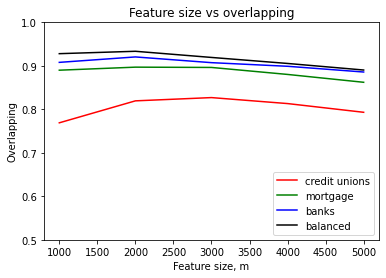

In [ ]:
# Plot degree of overlapping for different size m
x=[1000,2000,3000,4000,5000]
plt.plot(x,cu_wells,color="red",label="credit unions")
plt.plot(x,mortgages_wells,color="green",label="mortgage")
plt.plot(x,banks_wells,color="blue",label="banks")
plt.plot(x,balanced_wells,color="black",label="balanced")
plt.legend(loc="lower right")
plt.xlabel("Feature size, m")
plt.ylabel("Overlapping")
plt.title("Feature size vs overlapping")
plt.ylim(0.5, 1)
plt.show()

### Part 3 Approaches

#### 3.1 Overlapping frequent vocabulary (Adopted)

In [ ]:
# Count all vocaburary frequency in all dataset, set max_features to None
cu_vectorizer,X_cu=tokenizing(cu_complaint,None)
banks_vectorizer,X_banks=tokenizing(banks_complaint,None)
mortgages_vectorizer,X_mortgages=tokenizing(mortgages_complaint,None)
balanced_vectorizer,X_balanced=tokenizing(balanced_complaint,None)
wells_vectorizer,X_wells=tokenizing(wells_complaint,None)
cu_freq=X_cu.sum(axis=0)
banks_freq=X_banks.sum(axis=0)
mortgages_freq=X_mortgages.sum(axis=0)
balanced_freq=X_balanced.sum(axis=0)
wells_freq=X_wells.sum(axis=0)
cu_freq=np.sort(np.squeeze(np.asarray(cu_freq)))[::-1]/cu_freq.sum()
banks_freq=np.sort(np.squeeze(np.asarray(banks_freq)))[::-1]/banks_freq.sum()
mortgages_freq=np.sort(np.squeeze(np.asarray(mortgages_freq)))[::-1]/mortgages_freq.sum()
balanced_freq=np.sort(np.squeeze(np.asarray(balanced_freq)))[::-1]/balanced_freq.sum()
wells_freq=np.sort(np.squeeze(np.asarray(wells_freq)))[::-1]/wells_freq.sum()

In [ ]:
# Helper function for the plot
# Argument:
# Title: Str
# freq_array: np.array, shape=(#tokens,)
# bin_size: int, such as 1000,2000
# Threshold: float, such as 0.9, function will print first size when hit threshold
def m_vs_token(title,freq_array,bin_size,threshold):
  total_size=freq_array.shape[0]
  axis=[]
  total_freq=[]
  for i in range(bin_size,total_size,bin_size):
    axis.append(i)
    temp=freq_array[:i].sum()
    total_freq.append(temp)
  plt.figure(figsize=(10,5))
  plt.title(title,size=14)
  plt.xlabel("m size",size=14)
  plt.ylabel("token coverage",size=14)
  plt.plot(axis,total_freq)
  plt.show()
  k=0
  while total_freq[k]<threshold:
    k+=1
  print(axis[k])

In [ ]:
# set threshold for token coverage 0.9
coverage=0.9

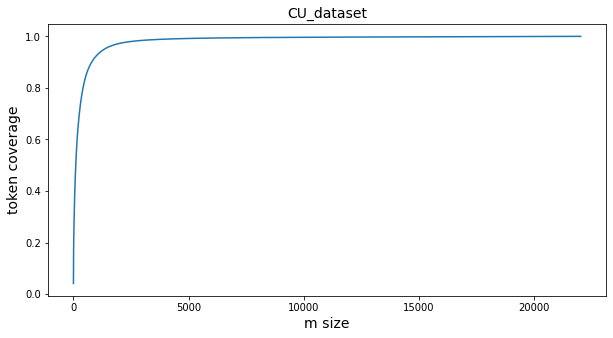

793


In [ ]:
m_vs_token("CU_dataset",cu_freq,1,coverage)

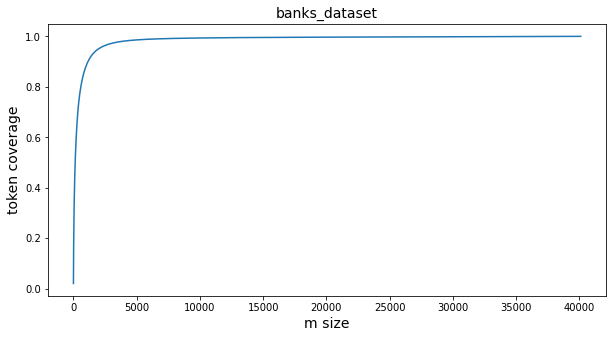

1150


In [ ]:
m_vs_token("banks_dataset",banks_freq,1,coverage)

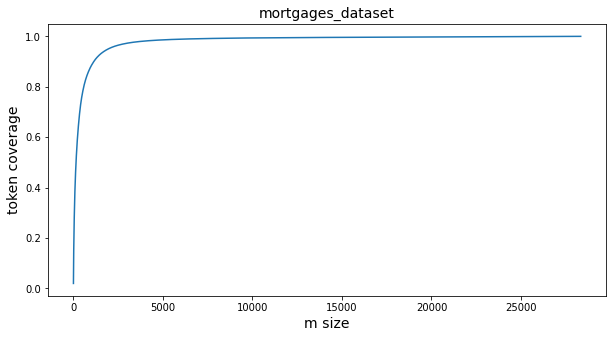

1138


In [ ]:
m_vs_token("mortgages_dataset",mortgages_freq,1,coverage)

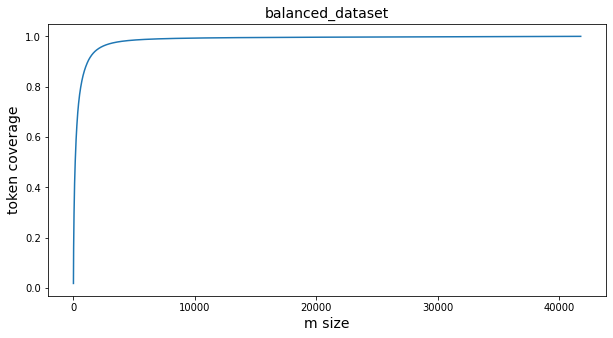

1189


In [ ]:
m_vs_token("balanced_dataset",balanced_freq,1,coverage)

Using M word computed above 

In [ ]:
Wells_M_size=None
#Tokenizer
cu_vectorizer,X_cu=tokenizing(cu_complaint,793)
banks_vectorizer,X_banks=tokenizing(banks_complaint,1150)
mortgages_vectorizer,X_mortgages=tokenizing(mortgages_complaint,1138)
balanced_vectorizer,X_balanced=tokenizing(balanced_complaint,1152)
wells_vectorizer,X_wells=tokenizing(wells_complaint,Wells_M_size)


cu_fq_words=cu_vectorizer.get_feature_names()
banks_fq_words=banks_vectorizer.get_feature_names()
mortgages_fq_words=mortgages_vectorizer.get_feature_names()
balanced_fq_words=balanced_vectorizer.get_feature_names()
wells_fq_words=wells_vectorizer.get_feature_names()

#calculating original sentence word count
smoothing=0.001
wells_words_count=X_wells.toarray().sum(axis=1)+smoothing

#finding overlaping words
wells_cu_overlap=set(cu_fq_words)&set(wells_fq_words)
wells_banks_overlap=set(banks_fq_words)&set(wells_fq_words)
wells_mortgages_overlap=set(mortgages_fq_words)&set(wells_fq_words)
wells_balanced_overlap=set(balanced_fq_words)&set(wells_fq_words)

#searching overlaping index
wells_cu_overlap_idx=[wells_vectorizer.vocabulary_[i] for i in wells_cu_overlap]
wells_banks_overlap_idx=[wells_vectorizer.vocabulary_[i] for i in wells_banks_overlap]
wells_mortgages_overlap_idx=[wells_vectorizer.vocabulary_[i] for i in wells_mortgages_overlap]
wells_balanced_overlap_idx=[wells_vectorizer.vocabulary_[i] for i in wells_balanced_overlap]

#calculating sentence ovelapping word count
wells_cu_overlap_word_count=X_wells[:,wells_cu_overlap_idx].toarray().sum(axis=1)
wells_banks_overlap_word_count=X_wells[:,wells_banks_overlap_idx].toarray().sum(axis=1)
wells_mortgages_overlap_word_count=X_wells[:,wells_mortgages_overlap_idx].toarray().sum(axis=1)
wells_balanced_overlap_word_count=X_wells[:,wells_balanced_overlap_idx].toarray().sum(axis=1)

#dividing sentence word count to get the score for each document
wells_cu_sentence_score=wells_cu_overlap_word_count/wells_words_count
wells_banks_sentence_score=wells_banks_overlap_word_count/wells_words_count
wells_mortgages_sentence_score=wells_mortgages_overlap_word_count/wells_words_count
wells_balanced_sentence_score=wells_balanced_overlap_word_count/wells_words_count

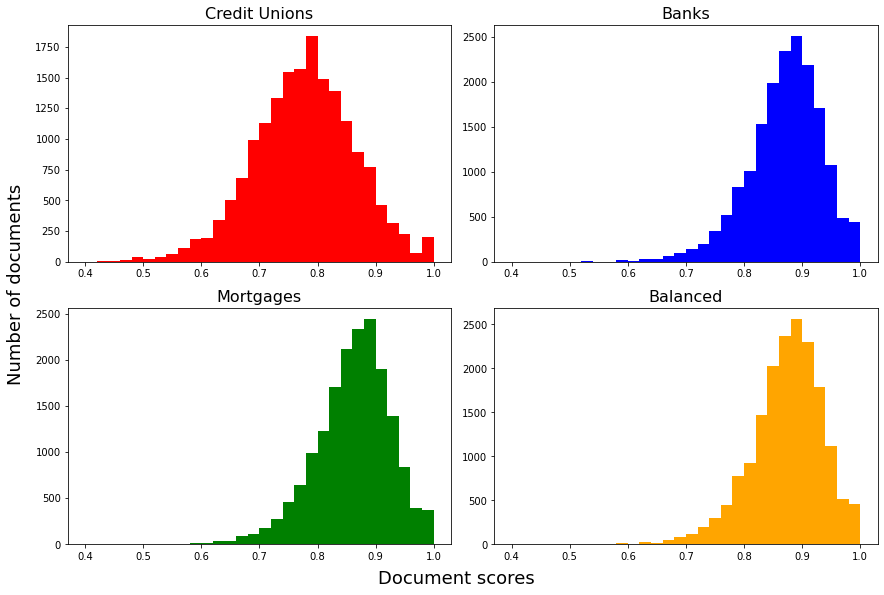

In [ ]:
#plotting
fig, ax = plt.subplots(2, 2,figsize=(12, 8))

ax[0,0].set_title("Credit Unions",fontsize=16)
ax[0,1].set_title("Banks",fontsize=16)
ax[1,0].set_title("Mortgages",fontsize=16)
ax[1,1].set_title("Balanced",fontsize=16)

ax[0,0].hist(wells_cu_sentence_score,bins=30,range=(0.4,1),color="red")
ax[0,1].hist(wells_banks_sentence_score,bins=30,range=(0.4,1),color="blue")
ax[1,0].hist(wells_mortgages_sentence_score,bins=30,range=(0.4,1),color="green")
ax[1,1].hist(wells_balanced_sentence_score,bins=30,range=(0.4,1),color="orange")

fig.text(0.5, -0.02, 'Document scores', ha='center',size=18)
fig.text(-0.02, 0.5, 'Number of documents', va='center', rotation='vertical',size=18)

fig.tight_layout()
plt.show()

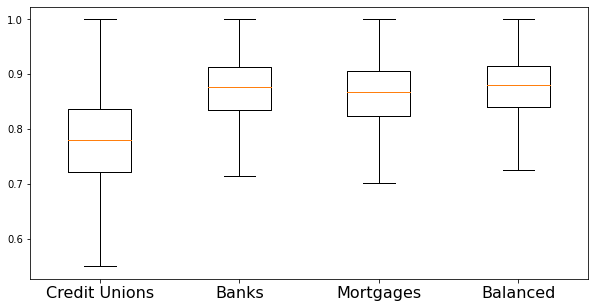

In [ ]:
plt.figure(figsize=(10,5))
box_plot = [wells_cu_sentence_score, wells_banks_sentence_score, wells_mortgages_sentence_score, wells_balanced_sentence_score]
plt.boxplot(box_plot,showfliers=False)
plt.xticks(np.arange(1,5),("Credit Unions","Banks","Mortgages","Balanced"),size=16)
plt.show()

#### Set threshold

In [ ]:
(np.mean(wells_cu_sentence_score)+np.mean(wells_banks_sentence_score)+np.mean(wells_mortgages_sentence_score)+np.mean(wells_balanced_sentence_score))/4

0.8456278197352383

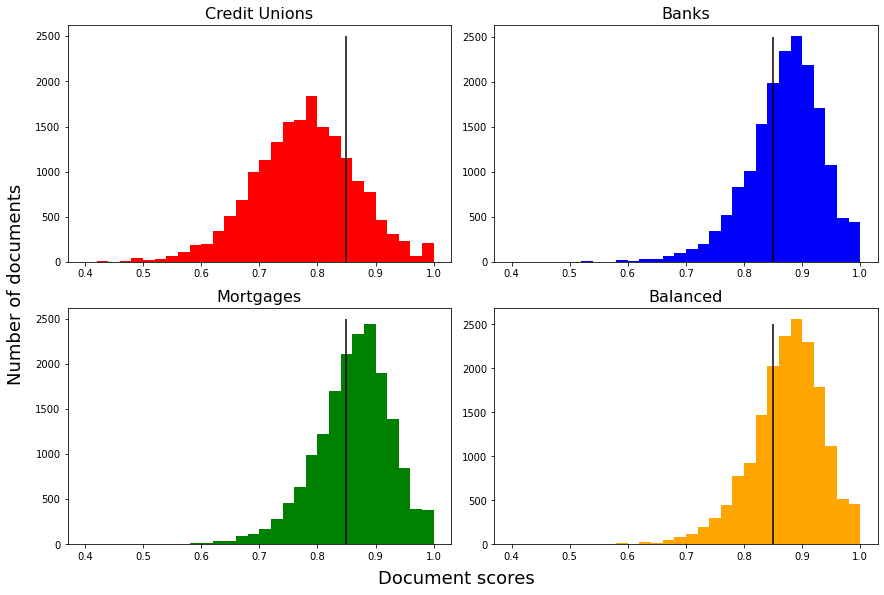

In [ ]:
Threshold1=0.85
#plotting
fig, ax = plt.subplots(2, 2,figsize=(12, 8))

ax[0,0].set_title("Credit Unions",fontsize=16)
ax[0,1].set_title("Banks",fontsize=16)
ax[1,0].set_title("Mortgages",fontsize=16)
ax[1,1].set_title("Balanced",fontsize=16)

ax[0,0].hist(wells_cu_sentence_score,bins=30,range=(0.4,1),color="red")
ax[0,1].hist(wells_banks_sentence_score,bins=30,range=(0.4,1),color="blue")
ax[1,0].hist(wells_mortgages_sentence_score,bins=30,range=(0.4,1),color="green")
ax[1,1].hist(wells_balanced_sentence_score,bins=30,range=(0.4,1),color="orange")
ax[0,0].vlines(x=Threshold1,ymin=0,ymax=2500)
ax[0,1].vlines(x=Threshold1,ymin=0,ymax=2500)
ax[1,0].vlines(x=Threshold1,ymin=0,ymax=2500)
ax[1,1].vlines(x=Threshold1,ymin=0,ymax=2500)

fig.text(0.5, -0.02, 'Document scores', ha='center',size=18)
fig.text(-0.02, 0.5, 'Number of documents', va='center', rotation='vertical',size=18)

fig.tight_layout()
plt.show()

In [ ]:
print(f'Credit Unions vendor set score',np.sum(wells_cu_sentence_score>Threshold1)/wells_cu_sentence_score.shape[0])
print(f'Banks vendor set score',np.sum(wells_banks_sentence_score>Threshold1)/wells_banks_sentence_score.shape[0])
print(f'Mortgages vendor set score',np.sum(wells_mortgages_sentence_score>Threshold1)/wells_mortgages_sentence_score.shape[0])
print(f'Balanced vendor set score',np.sum(wells_balanced_sentence_score>Threshold1)/wells_balanced_sentence_score.shape[0])

Credit Unions vendor set score 0.19638903082950093
Banks vendor set score 0.6691080451938909
Mortgages vendor set score 0.6126156815988191
Balanced vendor set score 0.6879577584738545


#### Approach 3.2 Overlapping frequent vocabulary with TFIDF coverage as score
(Method dropped in week 2)

In [ ]:
#tfidf overlap score computation
max_features=2000

cu_tfidf_vectorizer,X_tfidf_cu=tfidf_tokenizing(cu_complaint,max_features,"l1")
banks_tfidf_vectorizer,X_tfidf_banks=tfidf_tokenizing(banks_complaint,max_features,"l1")
mortgages_tfidf_vectorizer,X_tfidf_mortgages=tfidf_tokenizing(mortgages_complaint,max_features,"l1")
balanced_tfidf_vectorizer,X_tfidf_balanced=tfidf_tokenizing(balanced_complaint,max_features,"l1")
wells_tfidf_vectorizer,X_tfidf_wells=tfidf_tokenizing(wells_complaint,max_features,"l1")

cu_fq_tfidf_words=cu_tfidf_vectorizer.get_feature_names()
banks_fq_tfidf_words=banks_tfidf_vectorizer.get_feature_names()
mortgages_fq_tfidf_words=mortgages_tfidf_vectorizer.get_feature_names()
balanced_fq_tfidf_words=balanced_tfidf_vectorizer.get_feature_names()
wells_fq_tfidf_words=wells_tfidf_vectorizer.get_feature_names()

#finding overlaping words
wells_cu_tfidf_overlap=set(cu_fq_tfidf_words)&set(wells_fq_tfidf_words)
wells_banks_tfidf_overlap=set(banks_fq_tfidf_words)&set(wells_fq_tfidf_words)
wells_mortgages_tfidf_overlap=set(mortgages_fq_tfidf_words)&set(wells_fq_tfidf_words)
wells_balanced_tfidf_overlap=set(balanced_fq_tfidf_words)&set(wells_fq_tfidf_words)

#searching overlaping index
wells_cu_tfidf_overlap_idx=[wells_tfidf_vectorizer.vocabulary_[i] for i in wells_cu_tfidf_overlap]
wells_banks_tfidf_overlap_idx=[wells_tfidf_vectorizer.vocabulary_[i] for i in wells_banks_tfidf_overlap]
wells_mortgages_tfidf_overlap_idx=[wells_tfidf_vectorizer.vocabulary_[i] for i in wells_mortgages_tfidf_overlap]
wells_balanced_tfidf_overlap_idx=[wells_tfidf_vectorizer.vocabulary_[i] for i in wells_balanced_tfidf_overlap]

#calculating sentence ovelapping word count
wells_cu_tfidf_overlap_sum=X_tfidf_wells[:,wells_cu_tfidf_overlap_idx].toarray().sum(axis=1)
wells_banks_tfidf_overlap_sum=X_tfidf_wells[:,wells_banks_tfidf_overlap_idx].toarray().sum(axis=1)
wells_mortgages_tfidf_overlap_sum=X_tfidf_wells[:,wells_mortgages_tfidf_overlap_idx].toarray().sum(axis=1)
wells_balanced_tfidf_overlap_sum=X_tfidf_wells[:,wells_balanced_tfidf_overlap_idx].toarray().sum(axis=1)

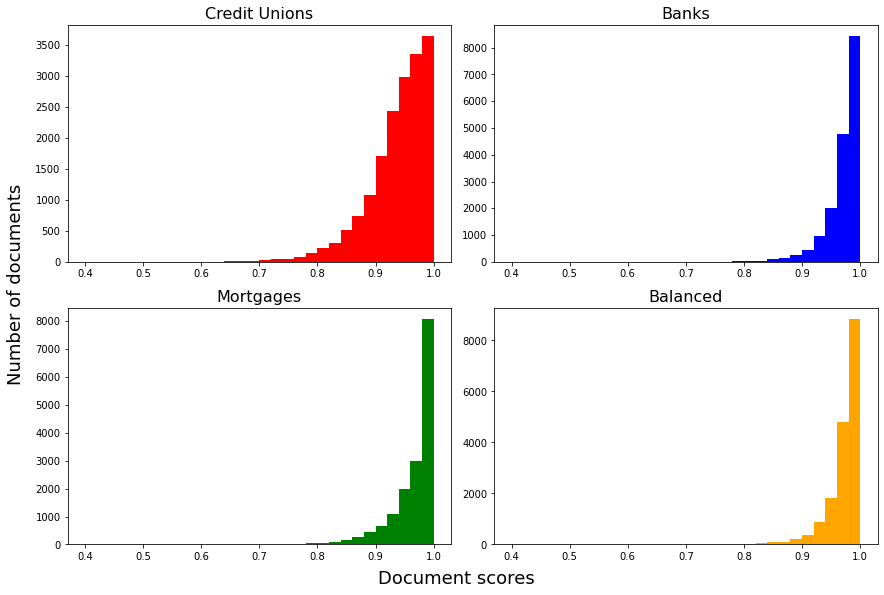

In [ ]:
#plot overlap distribution - tfidf tokenizer
wells_cu_tfidf_sentence_score=wells_cu_tfidf_overlap_sum
wells_banks_tfidf_sentence_score=wells_banks_tfidf_overlap_sum
wells_mortgages_tfidf_sentence_score=wells_mortgages_tfidf_overlap_sum
wells_balanced_tfidf_sentence_score=wells_balanced_tfidf_overlap_sum

#plotting
fig, ax = plt.subplots(2, 2,figsize=(12, 8))

ax[0,0].set_title("Credit Unions",fontsize=16)
ax[0,1].set_title("Banks",fontsize=16)
ax[1,0].set_title("Mortgages",fontsize=16)
ax[1,1].set_title("Balanced",fontsize=16)

ax[0,0].hist(wells_cu_tfidf_sentence_score,bins=30,range=(0.4,1),color="red")
ax[0,1].hist(wells_banks_tfidf_sentence_score,bins=30,range=(0.4,1),color="blue")
ax[1,0].hist(wells_mortgages_tfidf_sentence_score,bins=30,range=(0.4,1),color="green")
ax[1,1].hist(wells_balanced_tfidf_sentence_score,bins=30,range=(0.4,1),color="orange")

fig.text(0.5, -0.02, 'Document scores', ha='center',size=18)
fig.text(-0.02, 0.5, 'Number of documents', va='center', rotation='vertical',size=18)

fig.tight_layout()
plt.show()

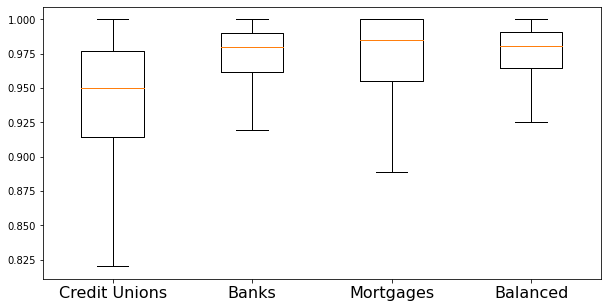

In [ ]:
plt.figure(figsize=(10,5))
box_plot = [wells_cu_tfidf_sentence_score, wells_banks_tfidf_sentence_score, wells_mortgages_tfidf_sentence_score, wells_balanced_tfidf_sentence_score]
plt.boxplot(box_plot,showfliers=False)
plt.xticks(np.arange(1,5),("Credit Unions","Banks","Mortgages","Balanced"),size=16)
plt.show()

#### Approach 3.3 Overlapping top TFIDF vocabulary 
(Method dropped in week 3 due to TFIDF score for vocabulary too close, therefore need too much vocab, need to find a way to extract important vocabulary based on TFIDF scores)

In [ ]:
#TFIDF score for individual word. TF calculated using whole dataset
#This is soley for deciding which vocaburay are selected and feature size.
#Reuse the code snippet to find full count tokenizer for all sets
cu_vectorizer,X_cu=tokenizing(cu_complaint,None)
banks_vectorizer,X_banks=tokenizing(banks_complaint,None)
mortgages_vectorizer,X_mortgages=tokenizing(mortgages_complaint,None)
balanced_vectorizer,X_balanced=tokenizing(balanced_complaint,None)
wells_vectorizer,X_wells=tokenizing(wells_complaint,None)

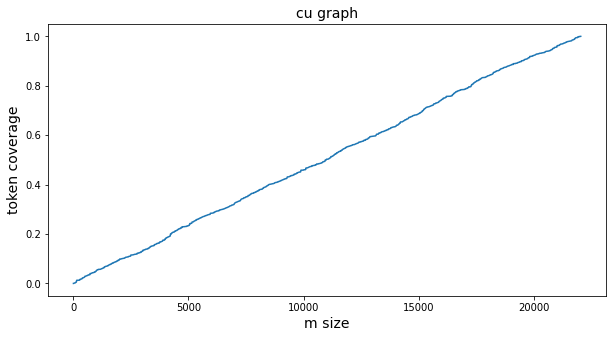

20810


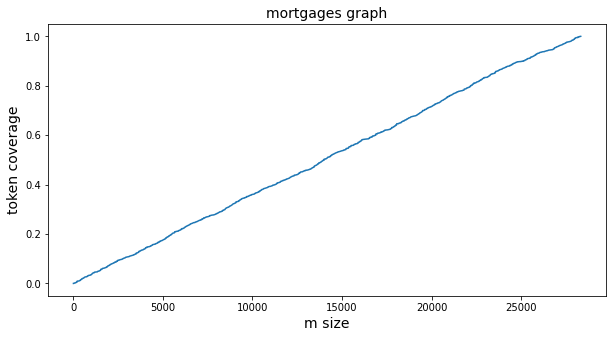

26850


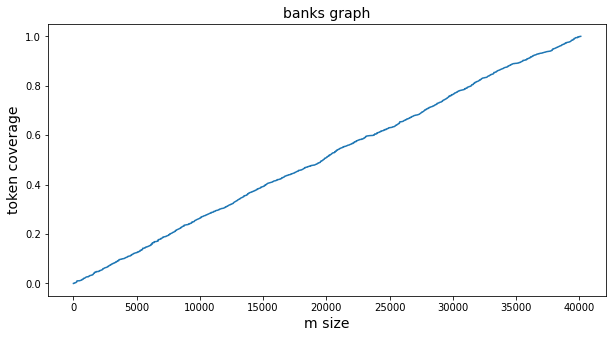

37970


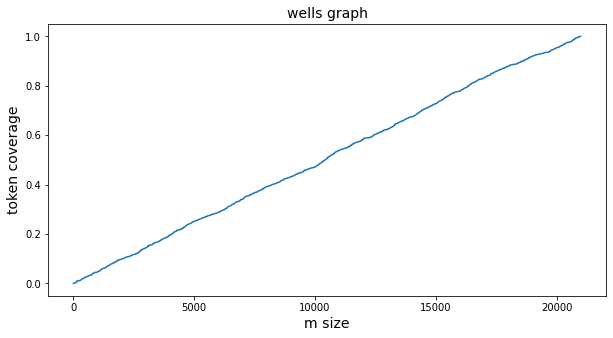

19930


In [ ]:
#Calculate each vocab's TF idf score
#cu dataset
cu_total_tfidf=np.asarray(np.multiply(X_cu.sum(axis=0),np.log(X_cu.shape[0]/((X_cu!=0).sum(axis=0)))))[0]
cu_total_tfidf_percent=cu_total_tfidf/sum(cu_total_tfidf)
m_vs_token("cu graph",cu_total_tfidf_percent,10,0.95)

#mortgage dataset
mortgages_total_tfidf=np.asarray(np.multiply(X_mortgages.sum(axis=0),np.log(X_mortgages.shape[0]/((X_mortgages!=0).sum(axis=0)))))[0]
mortgages_total_tfidf_percent=mortgages_total_tfidf/sum(mortgages_total_tfidf)
m_vs_token("mortgages graph",mortgages_total_tfidf_percent,10,0.95)

#banks dataset
banks_total_tfidf=np.asarray(np.multiply(X_banks.sum(axis=0),np.log(X_banks.shape[0]/((X_banks!=0).sum(axis=0)))))[0]
banks_total_tfidf_percent=banks_total_tfidf/sum(banks_total_tfidf)
m_vs_token("banks graph",banks_total_tfidf_percent,10,0.95)

#Wells Fargo datset
wells_total_tfidf=np.asarray(np.multiply(X_wells.sum(axis=0),np.log(X_wells.shape[0]/((X_wells!=0).sum(axis=0)))))[0]
wells_total_tfidf_percent=wells_total_tfidf/sum(wells_total_tfidf)
m_vs_token("wells graph",wells_total_tfidf_percent,10,0.95)

In [ ]:
#This code block is for finding index of top tfidf words in the dataset. Then find overlap vocabs between vendor vs Wells fargo dataset within these vocabs.
max_features=2000
#find top tfidf score word index from each dataset
cu_max_tfidf_idx=np.squeeze(np.asarray(cu_total_tfidf)).argsort()[-max_features:][::-1]
mortgages_max_tfidf_idx=np.squeeze(np.asarray(mortgages_total_tfidf)).argsort()[-max_features:][::-1]
banks_max_tfidf_idx=np.squeeze(np.asarray(banks_total_tfidf)).argsort()[-max_features:][::-1]
wells_max_tfidf_idx=np.squeeze(np.asarray(wells_total_tfidf)).argsort()[-max_features:][::-1]
#find vocab for all dataset
cu_vocab=cu_vectorizer.get_feature_names()
mortgages_vocab=mortgages_vectorizer.get_feature_names()
banks_vocab=banks_vectorizer.get_feature_names()
wells_vocab=wells_vectorizer.get_feature_names()
#find top tfidf score word from each dataset using the index
cu_max_tfidf_vocab=[cu_vocab[idx] for idx in cu_max_tfidf_idx]
mortgages_max_tfidf_vocab=[mortgages_vocab[idx] for idx in mortgages_max_tfidf_idx]
banks_max_tfidf_vocab=[banks_vocab[idx] for idx in banks_max_tfidf_idx]
wells_max_tfidf_vocab=[wells_vocab[idx] for idx in wells_max_tfidf_idx]
#find overlap vocab
cu_wells_overlap=list(set(cu_max_tfidf_vocab) & set(wells_max_tfidf_vocab))
banks_wells_overlap=list(set(mortgages_max_tfidf_vocab) & set(wells_max_tfidf_vocab))
mortgages_wells_overlap=list(set(banks_max_tfidf_vocab) & set(wells_max_tfidf_vocab))

In [ ]:
# Build pipeline and calculate TFIDF matrix for Wells Fargo dataset with wells_max_tfidf_vocab (wells fargo top tfidf vocabs).
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
corpus = wells_complaint
vocabulary = wells_max_tfidf_vocab
pipe = Pipeline([('count', CountVectorizer(vocabulary=vocabulary)),('tfid', TfidfTransformer(norm="l1"))]).fit(corpus)
wells_tfidf_matrix=pipe.transform(corpus).toarray()
cu_wells_overlap_idx=[pipe["count"].vocabulary_[i] for i in cu_wells_overlap]
mortgages_wells_overlap_idx=[pipe["count"].vocabulary_[i] for i in mortgages_wells_overlap]
banks_wells_overlap_idx=[pipe["count"].vocabulary_[i] for i in banks_wells_overlap]

In [ ]:
#calculating scores
wells_cu_tfidf_overlap_sum2=wells_tfidf_matrix[:,cu_wells_overlap_idx].sum(axis=1)
wells_banks_tfidf_overlap_sum2=wells_tfidf_matrix[:,banks_wells_overlap_idx].sum(axis=1)
wells_mortgages_tfidf_overlap_sum2=wells_tfidf_matrix[:,mortgages_wells_overlap_idx].sum(axis=1)

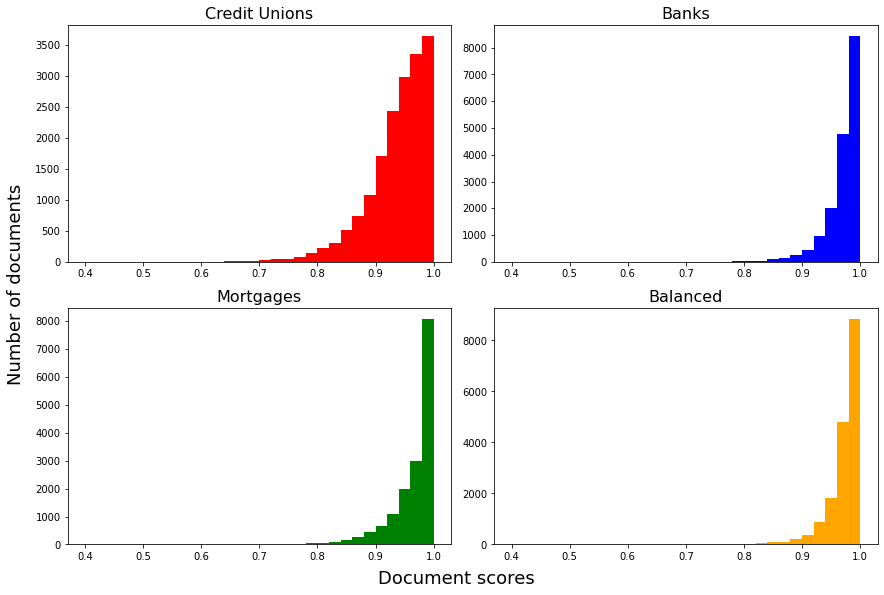

In [ ]:
#plot overlap distribution - tfidf tokenizer - top tfidf words
wells_cu_tfidf_sentence_score=wells_cu_tfidf_overlap_sum
wells_banks_tfidf_sentence_score=wells_banks_tfidf_overlap_sum
wells_mortgages_tfidf_sentence_score=wells_mortgages_tfidf_overlap_sum

#plotting
fig, ax = plt.subplots(2, 2,figsize=(12, 8))

ax[0,0].set_title("Credit Unions",fontsize=16)
ax[0,1].set_title("Banks",fontsize=16)
ax[1,0].set_title("Mortgages",fontsize=16)
ax[1,1].set_title("Balanced",fontsize=16)

ax[0,0].hist(wells_cu_tfidf_sentence_score,bins=30,range=(0.4,1),color="red")
ax[0,1].hist(wells_banks_tfidf_sentence_score,bins=30,range=(0.4,1),color="blue")
ax[1,0].hist(wells_mortgages_tfidf_sentence_score,bins=30,range=(0.4,1),color="green")
ax[1,1].hist(wells_balanced_tfidf_sentence_score,bins=30,range=(0.4,1),color="orange")

fig.text(0.5, -0.02, 'Document scores', ha='center',size=18)
fig.text(-0.02, 0.5, 'Number of documents', va='center', rotation='vertical',size=18)

fig.tight_layout()
plt.show()

#### Part 4 Toy Example code used in the first week.

In [ ]:
# code for toy sample
v_1=["debt card not work","lost debt card last night","debt card remain balance amount wrong"]
v_2=["mortgage payment not process","why mortgage payment not show up","mortgage payment amount not look correct"]
test=["debt card damage","mortgage payment amount show error","debt card not function atm machine"]
max_features=4
v1_vectorizer,_=tokenizing(v_1,max_features)
v2_vectorizer,_=tokenizing(v_2,max_features)
test_vectorizer,X_test=tokenizing(test,max_features)
overlap_v1_test=set(v1_vectorizer.get_feature_names())&set(test_vectorizer.get_feature_names())
overlap_v2_test=set(v2_vectorizer.get_feature_names())&set(test_vectorizer.get_feature_names())

In [ ]:
print(f'vendor dataset 1',v_1)
print(f'vendor dataset 2',v_2)
print(f'Wells Fargo dataset',test)
print("")
print("In this toy example, vendor dataset 1 is designed to be similar to test, and vendor dataset 2 is designed to be different to our dataset")
print("")
print(f'most frequent 4 words for vendor dataset 1:', v1_vectorizer.get_feature_names())
print(f'most frequent 4 words for vendor dataset 2:', v2_vectorizer.get_feature_names())
print("")
print(f'words count in Wells Fargo set', [3,5,6])
print(f'words count in Wells Fargo set with only frequent word in vendor set 1', [2,1,2])
print(f'socore distribution using vendor set 1', [round(2/(3+0.01),2),round(1/(5+0.01),2),round(2/(6+0.01),2)])
print(f'words count in Wells Fargo set with only frequent word in vendor set 2', [0,3,1])
print(f'socore distribution using vendor set 2', [0,round(3/(5+0.01),2),round(1/(6+0.01),2)])

vendor dataset 1 ['debt card not work', 'lost debt card last night', 'debt card remain balance amount wrong']
vendor dataset 2 ['mortgage payment not process', 'why mortgage payment not show up', 'mortgage payment amount not look correct']
Wells Fargo dataset ['debt card damage', 'mortgage payment amount show error', 'debt card not function atm machine']

In this toy example, vendor dataset 1 is designed to be similar to test, and vendor dataset 2 is designed to be different to our dataset

most frequent 4 words for vendor dataset 1: ['amount', 'balance', 'card', 'debt']
most frequent 4 words for vendor dataset 2: ['amount', 'mortgage', 'not', 'payment']

words count in Wells Fargo set [3, 5, 6]
words count in Wells Fargo set with only frequent word in vendor set 1 [2, 1, 2]
socore distribution using vendor set 1 [0.66, 0.2, 0.33]
words count in Wells Fargo set with only frequent word in vendor set 2 [0, 3, 1]
socore distribution using vendor set 2 [0, 0.6, 0.17]
